In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
from astropy.table import Table
from tqdm import tqdm
import numpy as np

try:
    import fitsio
    fitsread= fitsio.read
    fitswrite=fitsio.write
    headerread=fitsio.read_header
    _FITSIO_LOADED = True
    
except ImportError:
    import astropy.io.fits as pyfits
    fitsread= pyfits.getdata
    fitswrite=pyfits.writeto
    headerread=pyfits.getheader
    _FITSIO_LOADED = False

cat = Table.read("/data/jdli/sdss/dr17/allStar-dr17-synspec_rev1.fits")
# df = cat.to_pandas()

# print(cat.info)


In [3]:
names = [name for name in cat.colnames if len(cat[name].shape) <= 1]

df = cat[names].to_pandas()

In [4]:
gdf = df.copy()
# gdf = gdf.merge(df_raw[['GAIAEDR3_SOURCE_ID', 'tmass_id']])

mask_labels = (gdf['M_H']>-2.5) & (gdf['M_H']<0.6) &\
            (gdf['TEFF']>3000) & (gdf['TEFF']<7000) &\
            (gdf['LOGG']>0.) & (gdf['LOGG']<5.5) &\
            (gdf['ALPHA_M']>-1) & (gdf['ALPHA_M']<1) & (gdf['ASPCAPFLAG']==0) &\
            (gdf['LOGG_ERR']<0.1) & (gdf['TEFF_ERR']<50) &\
            (gdf['ALPHA_M_ERR']<0.02) & (gdf['M_H_ERR']<0.015)
        
# mask_photo = (gdf['J']>6) & (gdf['J']<14.) &\
#             (gdf['H']>6) & (gdf['H']<14.) &\
#             (gdf['K']>6) & (gdf['K']<14.) &\
#             (gdf['Qfl_J']=='A') & (gdf['Qfl_H']=='A') & (gdf['Qfl_K']=='A')&\
#             (gdf['W1mag']>6) & (gdf['W1mag']<13.) &\
#             (gdf['W2mag']>6) & (gdf['W2mag']<13.) &\
#             (gdf['qph_w1']=='A') & (gdf['qph_w2']=='A')

# mask_spec = (gdf['snr_bp10']>100.) & (gdf['snr_bp55']>1.) &\
#             (gdf['snr_rp10']>100.) & (gdf['snr_rp55']>1.)

# mask  = mask_labels & mask_photo & mask_spec
mask = mask_labels

# print(gdf.shape, gdf[mask_labels].shape, gdf[mask_photo].shape, gdf[mask_spec].shape)
print(gdf[mask].shape)

(332904, 215)


In [54]:
gdf[mask].to_csv("/data/jdli/gaia/ap17_332904.csv", index=False)



In [5]:
# gdf[mask].to_csv("/data/jdli/sdss/dr17/ap17_lbcut.csv", index=False)

adf = gdf[mask].copy(deep=True)

def convert_string_uft8(series):
    return [s.decode('utf-8').strip() for s in series]

adf['APOGEE_ID'] = convert_string_uft8(adf['APOGEE_ID'])
adf['TELESCOPE'] = convert_string_uft8(adf['TELESCOPE'])
adf['FIELD']     = convert_string_uft8(adf['FIELD'])

print(adf['TELESCOPE'].unique(), "\n", adf['FIELD'].unique())

['apo25m' 'lco25m' 'apo1m'] 
 ['120+12' '116-04' 'N7789' ... 'K2_C12_083-66_btx' 'sgr_tidal10'
 'K2_C12_089-63_btx']


In [6]:
import multiprocessing
import urllib.request

spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
n_split = 268247

def download_spectrum(telescope, field, apogee_id, save_dir=spec_dir):
    
    # if not os.path.exists(save_dir):
    #     print("make dir %s"%save_dir)
    #     os.makedirs(save_dir)
    
    url = f"https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{telescope}/{field}/aspcapStar-dr17-{apogee_id}.fits"
    filename = f"{apogee_id}.fits"
    filepath = save_dir+filename
    
    if not os.path.exists(filepath):
        try: 
            urllib.request.urlretrieve(url, save_dir+filename)
        except Exception:
            print(f"no such a spectra of APOGEE_ID = {apogee_id}")
    

# Number of parallel processes
num_processes = 64

# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    
    pool.starmap(download_spectrum, tqdm(
        zip(adf['TELESCOPE'].values[n_split:], 
            adf['FIELD'].values[n_split:], 
            adf['APOGEE_ID'].values[n_split:],
           ), total=len(adf)-n_split))


100%|█████████████████████████████████████████████████████████████████| 64657/64657 [00:00<00:00, 185785.77it/s]


In [7]:
spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
ava_spec_names = os.listdir(spec_dir)
print(len(ava_spec_names))

cat_spec_names = [f"{i}.fits" for i in adf['APOGEE_ID'].values]
print(len(cat_spec_names))

res_spec_names = list(set(cat_spec_names) - set(ava_spec_names))
print(len(res_spec_names))

268378
332904
42623


In [109]:
def read_spec(fname):
    # pri_header = headerread(fname, 0, memmap=False)
    hdul = fits.open(fname)
    
    try:
        flux = fitsread(fname, 1, memmap=False)
        e_flux = fitsread(fname, 2, memmap=False)
        mask = fitsread(fname, 3, memmap=False)
        tmass_id = hdul[4].data[0][1]
    except:
        flux, e_flux, mask = np.nan,  np.nan,  np.nan 
        tmass_id = np.nan
    # if (len(flux.shape)>1)&(len(e_flux.shape)>1)&(len(mask.shape)>1):
    #     flux, e_flux, mask = flux[0], e_flux[0], mask[0]
    # else:
    #     flux, e_flux, mask = np.nan,  np.nan,  np.nan 
    
    hdul.close()
    return {'tmass_id':tmass_id, 'flux':flux, 'fluxerr':e_flux, 'mask':mask}

x = read_spec(spec_dir+ava_spec_names[0])

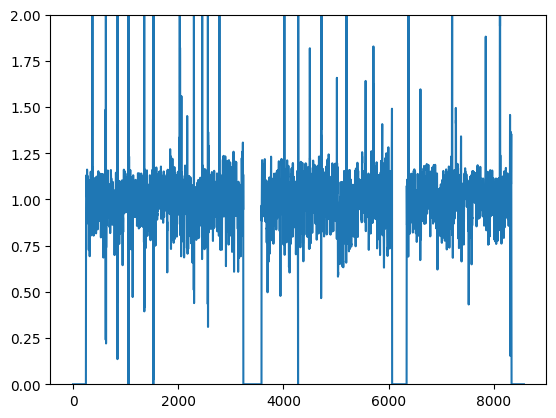

In [100]:
import matplotlib.pyplot as plt

x = read_spec(spec_dir+ava_spec_names[0])
plt.plot(x['flux'])
len(x['flux'])
plt.ylim([0., 2]);

In [ ]:
# # plt.plot(x['mask']*x['flux'])
# tmass_ids = []
# fluxes = []
# fluxerrs = []
# masks = []

# for sp_name in tqdm(ava_spec_names):
    
#     spec_dict = read_spec(spec_dir+sp_name)
#     tmass_ids.append(spec_dict['tmass_id'])
#     fluxes.append(spec_dict['flux'])
#     fluxerrs.append(spec_dict['fluxerr'])
#     masks.append(spec_dict['mask'])
    

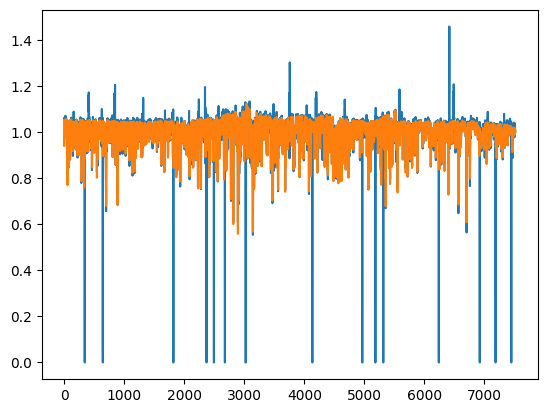

In [144]:
# plt.plot(result[10]['flux'])
# plt.plot(result[10]['mask'])
# plt.scatter(result[10]['flux'], result[10]['mask'])
ind = (result[10]['mask']>0)
plt.plot(result[10]['flux'][ind])
plt.plot(result[10]['mask'][ind])

In [110]:
# Number of parallel processes
num_processes = 64
ava_spec_paths = [spec_dir+s for s in ava_spec_names]

# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    
    result = pool.map(read_spec, tqdm(ava_spec_paths))

 25%|████████████████████████████████████████▏                                                                                                                        | 67007/268378 [00:14<00:01, 143313.37it/s]WARNING: File may have been truncated: actual file length (8192) is smaller than the expected size (74880) [astropy.io.fits.file]
    Header size is not multiple of 2880: 18688
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 18688
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 18688
 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                | 135321/268378 [03:18<16:51, 131.53it/s]WARNING: VerifyWarning: Error validating header for HDU #4 (note: Astropy uses zero-based indexing).
    Header

In [165]:
result[0]

{'tmass_id': '2M17332599-3043089',
 'flux': array([0., 0., 0., ..., 0., 0., 0.]),
 'fluxerr': array([0., 0., 0., ..., 0., 0., 0.]),
 'mask': array([0., 0., 0., ..., 0., 0., 0.])}

In [166]:
tmass_ids = [x['tmass_id'] for x in result]
fluxes = [x['flux'] for x in result]
fluxerrs = [x['fluxerr'] for x in result]

In [187]:
pdf = pd.DataFrame({'tmass_id':tmass_ids, 'flux':fluxes, 'fluxerrs':fluxerrs})

pdf = pd.merge(adf, pdf, how='right', right_on='tmass_id', left_on='APOGEE_ID')

In [200]:
print(len(pdf))
# ind_spec = (pdf['tmass_id']!=np.nan) & (pdf['flux']!=np.nan) & (pdf['fluxerrs']!=np.nan) & (pdf['GAIAEDR3_SOURCE_ID']!=np.nan)
pdf = pdf.dropna(subset=['tmass_id', 'flux', 'fluxerrs', 'GAIAEDR3_SOURCE_ID'])

print(pdf.shape)
pdf['GAIAEDR3_SOURCE_ID'] = pdf['GAIAEDR3_SOURCE_ID'].astype(int)

286932
(286932, 218)


In [216]:
xp_spec = np.load("/data/jdli/gaia/ap_xp_233985.npy", allow_pickle=True).item()

xp_spec_df = pd.DataFrame(
    {'source_id':xp_spec['source_id'], 
     'xp':list(xp_spec['x']), 'xp_mask':list(xp_spec['x_mask']), 
     'label':list(xp_spec['y']), 'e_label':list(xp_spec['e_y'])}
)

In [221]:
xp_ap_spec = pd.merge(xp_spec_df, pdf, right_on='GAIAEDR3_SOURCE_ID', left_on='source_id')

xp_ap_spec.shape

(173344, 223)

In [256]:
xp = np.array([x for x in xp_ap_spec['xp'].values])
xp_mask = np.array([x for x in xp_ap_spec['xp_mask'].values])
label = np.array([x for x in xp_ap_spec['label'].values])
e_label = np.array([x for x in xp_ap_spec['e_label'].values])


In [229]:
flux_arr = np.array([x for x in xp_ap_spec['flux'].values])
flux_err_arr = np.array([x for x in xp_ap_spec['fluxerrs'].values])



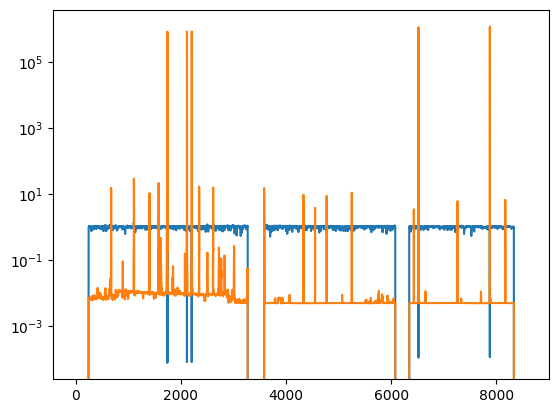

In [253]:
plt.plot(flux_arr[0])
plt.plot(flux_err_arr[0])
plt.yscale('log')

In [282]:
snr = flux_arr * flux_err_arr**-1
ind = snr>100

plt.plot(flux_arr[0][ind[0]])
plt.plot(flux_err_arr[0][ind[0]])
plt.yscale('log')

/tmp/ipykernel_46142/3306750881.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  snr = flux_arr * flux_err_arr**-1
/tmp/ipykernel_46142/3306750881.py:1: RuntimeWarning: invalid value encountered in multiply
  snr = flux_arr * flux_err_arr**-1


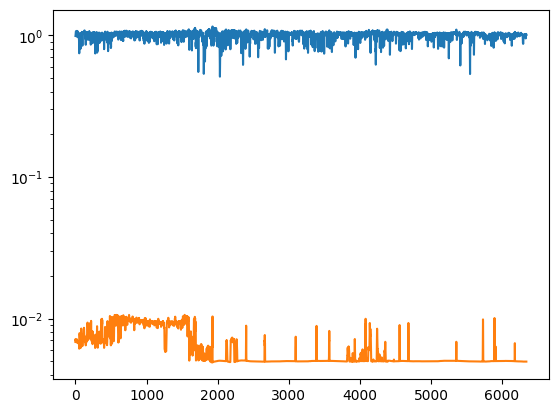

In [283]:
plt.plot(flux_arr[0][ind[0]])
plt.plot(flux_err_arr[0][ind[0]])
plt.yscale('log')

# data normalization

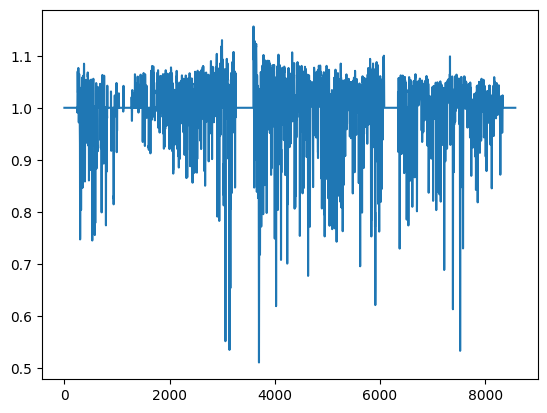

In [286]:
flux_mask = flux_arr

flux_mask[~ind] = 1.

plt.plot(flux_mask[0])

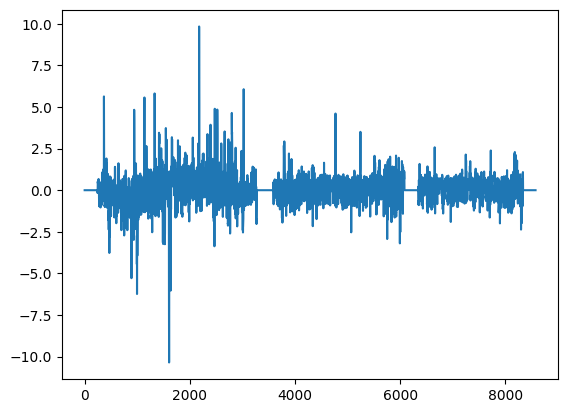

In [287]:
from sklearn import preprocessing
import joblib

scaler_ap = preprocessing.RobustScaler(quantile_range=(25, 75))
norm_flux = scaler_ap.fit_transform(flux_mask)
# norm_flux_err = flux_arr / scaler_ap.scale_

plt.plot(norm_flux[0])
joblib.dump(scaler_ap, '../models/scaler_ap.gz')


In [291]:
# new_resolution = 200
new_resolution = 64
raw_resolution = 8575

# n_avg = int(raw_resolution / new_resolution)
n_avg = 128

# Reshape the data into the desired number of data points for averaging
reshaped_flux = norm_flux[:,:n_avg*new_resolution].reshape(-1, new_resolution, n_avg)
# reshaped_fluxerr = norm_flux_err[:,:n_avg*new_resolution].reshape(-1, new_resolution, n_avg)

# Average the values for each group of data points
# flux_avg = np.mean(reshaped_flux, axis=2)
# fluxerr_avg = np.mean(np.abs(reshaped_fluxerr), axis=2)

print(reshaped_flux.shape)


(173344, 64, 128) (173344, 200)


In [302]:
import pickle

save_data = {
    "xp":xp, 'ap':reshaped_flux,
    "xp_mask":xp_mask,
    "y":label, 
    "e_y":e_label, 
    "source_id":xp_ap_spec['source_id'].values
}

data_dir = "/data/jdli/gaia/"
fname = "apspec_xp_173344.dump"
# np.savez(data_dir+fname, save_data, protocol=4)

with open(data_dir+fname, 'wb') as pfile:
    pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)
    

In [303]:
with open(data_dir+fname, 'rb') as pfile:
    data = pickle.load(pfile)

In [308]:
np.random.seed(27)

select_no_ap_ind = np.random.choice(reshaped_flux.shape[0], int(0.5*reshaped_flux.shape[0]))
reshaped_flux_zero = reshaped_flux
reshaped_flux_zero[select_no_ap_ind,:,:] = 0



In [310]:
save_data = {
    "xp":xp, 'ap':reshaped_flux_zero,
    "xp_mask":xp_mask,
    "y":label, 
    "e_y":e_label, 
    "source_id":xp_ap_spec['source_id'].values
}

data_dir = "/data/jdli/gaia/"
fname = "apspec_xp_173344_apzero.dump"
# np.savez(data_dir+fname, save_data, protocol=4)

with open(data_dir+fname, 'wb') as pfile:
    pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)

In [272]:
# save_data = {
#     "x":np.c_[xp, flux_avg],
#     "x_mask":np.c_[xp_mask, np.zeros_like(flux_avg, dtype=bool)],
#     "y":label, 
#     "e_y":e_label, 
#     "source_id":xp_ap_spec['source_id'].values
# }

# data_dir = "/data/jdli/gaia/"
# fname = "apspec_xp_173344.npy"
# np.save(data_dir+fname, save_data)

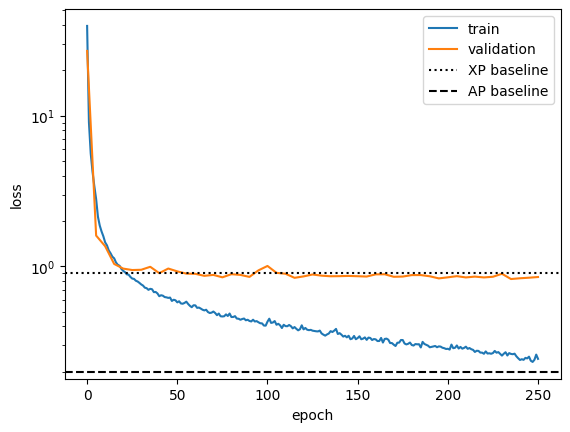

In [133]:
loss_dict = np.load("../check/loss.npy", allow_pickle=True).item()
n_val = np.arange(len(loss_dict['val_loss']))*5


plt.plot(loss_dict['tr_loss'], label='train')
plt.plot(n_val,loss_dict['val_loss'], label='validation')
plt.yscale('log')
plt.ylabel('loss');
plt.xlabel('epoch');


plt.axhline(0.9, label='XP baseline', c='k', ls=':');
plt.axhline(0.2, label='AP baseline', c='k', ls='--');
plt.legend();

In [ ]:
# normspecDict_trlst = []
# normspecDict_vallst= []

# for i in tqdm(range(len(specDict_lst))):
#     d = specDict_lst[i]
    
#     # try:
#     spec = d['flux']
#     spec_err = d['fluxerr']
#     spec_mask = d['mask']

#     norm_spec, norm_spec_err = apogee_continuum(
#         spec, spec_err, bitmask=spec_mask, dr=14
#     )

#     ind = df['2MASS_ID'].str.decode("utf-8")==d['tmass_id']

#     prlx, e_prlx = df[ind]['Gaia_parallax'].values, df[ind]['Gaia_parallax_err'].values
#     prlx_hogg, e_prlx_hogg = df[ind]['spec_parallax'].values, df[ind]['spec_parallax_err'].values
#     mags = df[['Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag']][ind].values

#     data = {'norm_spec':norm_spec, 'norm_spec_err':norm_spec_err, 
#             'mag':mags, 
#             'tmass_id':d['tmass_id'], 
#             'Gaia_parallax':prlx,  'Gaia_parallax_err':e_prlx, 
#             'spec_parallax':prlx_hogg, 'spec_parallax_err':e_prlx_hogg,}

#     if df[ind]['training_set'].values==1:
#         normspecDict_trlst.append(data)
#     elif df[ind]['training_set'].values==0:
#         normspecDict_vallst.append(data)
#     else:
#         print(df['training_set'][ind].values)
            
#     # except:
#     #     print("normalization failed")
        
# print(len(normspecDict_trlst), len(normspecDict_vallst))